# 1. Softmax logistic regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data = pd.read_csv("data/MNIST_train.csv").values

X_data = data[:, 1:]
Y_data = data[:, [0]]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state = 0)

print("Number of training examples = " + str(X_train.shape[0]) )
print("Number of testing examples = " + str(X_test.shape[0]) )
print("Number of features = " +  str(X_train.shape[1]) )

Number of training examples = 31500
Number of testing examples = 10500
Number of features = 784


Text(0.5,1,'label is [5]')

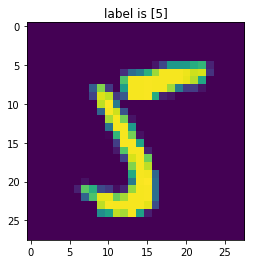

In [3]:
index = 10
sampleImg = np.reshape(X_train[index, :], [28, 28])

ax = plt.imshow(sampleImg)
plt.title("label is " + str(Y_train[index, :]))

Simple standardization for images

In [4]:
X_train = X_train / 255
X_test = X_test / 255

Convert labels to its one-hot encoding for defining the loss function of softmax classification

In [5]:
def one_hot_matrix(Y, num_class):
    """
    Convert an array of Y to its one_hot_matrix
    
    Arguments:
    Y -- array (number of examples, 1)
    num_class -- num of classes
    
    Return:
    Y_one_hot -- (number of examples, num_class)
    """
    Y_one_hot = np.zeros((Y.shape[0], num_class))
    Y_one_hot[np.arange(Y.shape[0]), Y.T] = 1
    
    return Y_one_hot

In [6]:
Y_train_one_hot = one_hot_matrix(Y_train, 10)
Y_test_one_hot = one_hot_matrix(Y_test, 10)

index = 2
print("Letter " + str(Y_train[index, 0]) + " converted to " + str(Y_train_one_hot[index, :]))

Letter 9 converted to [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Math for one training example
###  1. Forward propagation

We treate the softmax classification problem as a 1-layer neural network with 10 nerons (add image). Each neural is just a linear combination of all input features, and the softmax activation function takes effect for all neurons.

For one example $\{x_1, ..., x_{n} \}$ (use column vectors in the following for legibility):

#### Linear forward

$$
Z
=
\begin{bmatrix} 
z_1 \\
\vdots \\
z_j \\
\vdots \\
z_{10} \\
\end{bmatrix}
=
\begin{bmatrix} 
\sum\limits_{i=1}^{n} w_{i, 1} x_{i} \\
\vdots \\
\sum\limits_{i=1}^{n} w_{i, j} x_{i} \\
\vdots \\
\sum\limits_{i=1}^{n} w_{i, 10} x_{i} \\
\end{bmatrix}
+
\begin{bmatrix} 
b_1 \\
\vdots \\
b_j \\
\vdots \\
b_{10} \\
\end{bmatrix}
$$

#### Softmax

$$
\begin{bmatrix} 
z_1 \\
\vdots \\
z_{10} \\
\end{bmatrix}
\Rightarrow 
\begin{bmatrix} 
\frac{e^{z_1} }{\sum\limits_{k = 1}^{10} e^{z_k} } \\
\vdots \\
\frac{e^{z_10} }{\sum\limits_{k = 1}^{10} e^{z_k} } \\
\end{bmatrix}
=
\begin{bmatrix} 
a_1 \\
\vdots \\
a_{10} \\
\end{bmatrix}
=
a
$$


### 2. Cross entropy loss


$$\mathcal{L}(a, y) = -\sum\limits_{j =1} ^{10} y_{j} \log a_{j}$$

### 3. Backward propagation

#### 1. Derivative of linear function

$$\frac{\partial z_j }{\partial w_{i, j}} =  x_i $$
$$\frac{\partial z_j }{\partial b_{j}} =  1 $$


#### 2. Derivative of the softmax function

Let $\Omega =  \sum\limits_{k = 1}^{10} e^{z_k}$, let compute the partial derivatives for the Jacobian matrix (10 x 10) $\frac{\partial a_p}{\partial z_q}$:

$$
\begin{split}
\text{if} \; p = q :& \frac{\partial a_p}{\partial z_p} = \frac{\partial \frac{e^{z_p}}{\Omega}}{\partial z_p} = \frac{e^{z_p}\Omega - e^{z_p}e^{z_p}}{\Omega^2} = \frac{e^{z_p}}{\Omega}\frac{\Omega - e^{z_p}}{\Omega} = \frac{e^{z_p}}{\Omega}(1-\frac{e^{z_p}}{\Omega}) =  y_p (1 - y_p)\\
\text{if} \; p \neq q :& \frac{\partial y_p}{\partial z_q} = \frac{\partial \frac{e^{z_p}}{\Omega}}{\partial z_q} = \frac{0 - e^{z_p}e^{z_q}}{\Omega^2} = -\frac{e^{z_p}}{\Omega} \frac{e^{z_1}}{\Omega} = -y_p y_q
\end{split}$$

#### 3. Derivative of the cross entropy loss for the softmax function
$$\begin{split}
\frac{\partial \mathcal{L}}{\partial z_i} & = - \sum_{j=1}^{10} \frac{\partial y_j log(a_j)}{\partial z_i}{} =
- \sum_{j=1}^{10} y_j \frac{\partial log(a_j)}{\partial z_i} = - \sum_{j=1}^{10} y_j \frac{1}{a_j} \frac{\partial a_j}{\partial z_i} \\
& = - \frac{y_i}{a_i} \frac{\partial a_i}{\partial z_i} - \sum_{j \neq i}^{10} \frac{y_j}{a_j} \frac{\partial a_j}{\partial z_i}
= - \frac{y_i}{a_i} a_i (1-a_i) - \sum_{j \neq i}^{10} \frac{y_j}{a_j} (-a_j a_i) \\
& = - y_i + y_i a_i + \sum_{j \neq i}^{10} y_j a_i = - y_i + \sum_{j = 1}^{10} y_j a_i
= -y_i + a_i \sum_{j = 1}^{10} y_j \\
& = a_i - y_i
\end{split}$$

#### 3. Derivative of the cross entropy loss for $w$ and $b$

$$\frac{\partial \mathcal{L} }{\partial w_{i, j}} = \frac{\partial \mathcal{L}}{\partial z_j} \frac{\partial z_j }{\partial w_{i, j}} = (a_j - y_j) x_i $$

$$\frac{\partial \mathcal{L} }{\partial b_{j}} = \frac{\partial \mathcal{L}}{\partial z_j} \frac{\partial z_j }{\partial b_{j}} = a_j - y_j $$

## Vectorization for m training examples 


### 1. Forward propagation
let's use the convention that the data matrix $X$ with shape $m \times n$ has $m$ training examples and $n$ features for each example:

$$
X_{(m, n)}
=
\begin{bmatrix} 
\dots x^{(1)} \dots \\
\vdots \\
\dots x^{(m)} \dots \\
\end{bmatrix}
$$

$$
W_{(n, 10)}
=
\begin{bmatrix} 
\vdots \dots \vdots \\w^{(1)} \dots w^{(10)} \\ \vdots \dots \vdots \\
\end{bmatrix}
$$

$$
Z_{(m, 10)} = X W
$$

$$
A_{(m, 10)} = \text{softmax}(Z_{(m, 10)})
$$

Also, we have $Y_{(m, 10)}$, then the cross entropy loss is:
$$
J = - \frac{1}{m} || Y * \log A ||_{F} = - \frac{1}{m} \sum\limits_{i=1}^m \sum\limits_{j=1}^{10} Y_{i,j} \log A_{i,j}
$$

### 2. Backward propagation
$$
dZ = Y - A
$$
$$
dW = \frac{1}{m} X^T (Y - A)
$$
$$
db = \frac{1}{m} (Y - A).sum(axis = 0)
$$

In [7]:
def linear_forward(X, W, b):
    """
    Arguments:
    X -- data matrix (m, n)
    W -- weight matrix (n, num of class)
    b -- bias vector (1, num of class)
    
    Return: 
    Z -- input of activation function (m, 10)
    """
    
    Z = np.dot(X, W) + b
    
    
    
    assert(Z.shape == (X.shape[0], W.shape[1]) )
    
    return Z

In [8]:
def soft_max(Z):
    """
    Arguments:
    Z -- (m, num of class)
    
    Return:
    A -- softmax matrix (m, num of class) 
    """
    exp_Z = np.exp(Z)
    A = exp_Z / exp_Z.sum(axis = 1, keepdims = True) # sum along columns
    
    assert(A.shape == Z.shape )
    
    return A

In [9]:
def initialize_parameters(n, num_class):
    """
    Return:
    W -- (n, num of class)
    b -- (1, num of class)
    """
    np.random.seed(1)
    W = np.random.randn(n, num_class)
    b = np.zeros((1, num_class))
    
    return W, b

## 2. Compute the cost function
The cross entropy loss function for one example is $\mathcal{L}(a, y) = -\sum\limits_{j = 1}^{10} a_{j} \log y_{j}$. The overall loss is just the average of $\mathcal{L}$ over all training examples: $$J = \frac{1}{m} \sum\limits_{i = 1}^{m} \mathcal{L}(a^{(i)}, y^{(i)}) $$

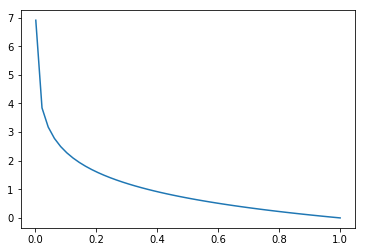

In [10]:
x = np.linspace(0.001, 1)
y = - np.log(x)
plt.plot(x, y)

If $a_j = 1$, the cost function want $y_j$ to be large while it heavily penalizes small $y_j$. 

In [11]:
def compute_cross_entropy_loss(A, Y):
    """
    Arguments:
    A -- prediction matrix of shape   (num of examples, num of class)
    Y -- one-hot matrix of true class (num of examples, num of class)
    Return:
    lost (scalar)
    """
    m = A.shape[0]
    return -(Y * np.log(A)).sum() / m
    

In [12]:
def backward_propagation(X, A, Y):
    """
    Arguments:
    X -- data matrix shape:  (m, n)
    A -- output of softmax:  (m, 10)
    Y -- one-hot true labels:(m, 10)
    """
    m = X.shape[0]
    
    dZ = A - Y
    dW = 1/m * np.dot(X.T, dZ)
    db = 1/m * np.sum(dZ, axis = 0, keepdims = True)
    
    return dW, db

Now Let's verify the correctness of our backward propagation using gradient checking. The idea is to compare the analytical derivatives to the numerical derivatives using central difference. Let's just do this for weight matrix $W$

In [13]:
def gradient_check(W, dW, X, Y, epsilon = 1e-7):
    """
    Arguments:
    W --  current weight matrix (num of feature, 10)
    dW -- analytical derivative matrix (num of feature, 10)
    X --  data matrix (num of examples, num of feature)
    Y --  one-hot label (num of examples, 10)
    
    Return:
    difference
    """
    gradApprox = np.zeros((dW.shape[0], dW.shape[1]))
    for i in range(0, W.shape[0]):
        for j in range(0, W.shape[1]):
            W_plus = np.copy(W)
            W_minus = np.copy(W)
            
            W_plus[i, j] = W_plus[i, j] + epsilon
            W_minus[i, j] = W_minus[i, j] - epsilon
            
            Z_plus = linear_forward(X, W_plus, b)
            A_plus = soft_max(Z_plus)
            J_plus = compute_cross_entropy_loss(A_plus, Y)

            Z_minus = linear_forward(X, W_minus, b)
            A_minus = soft_max(Z_minus)
            J_minus = compute_cross_entropy_loss(A_minus, Y)
            
            gradApprox[i, j] = (J_plus - J_minus) / (2*epsilon)
            
    # Compare gradients
    numerator = np.linalg.norm(gradApprox - dW)
    denominator = np.linalg.norm(dW) + np.linalg.norm(gradApprox)
    difference = numerator / denominator
    
    if difference > 3e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [14]:
num_feature = X_train.shape[1]
num_class = 10

W, b = initialize_parameters(num_feature, num_class)
Z = linear_forward(X_train, W, b)
A = soft_max(Z)
dW, db = backward_propagation(X_train, A, Y_train_one_hot)

gradient_check(W, dW, X_train, Y_train_one_hot, epsilon = 1e-7)

Your backward propagation works perfectly fine! difference = 2.545963816174567e-07


2.545963816174567e-07

In [15]:
def mclr_model(X, Y, num_iterations = 10000, learning_rate = 1.0, print_cost = False):
    """
    Arguments:
    X -- data matrix of shape:    (m, n)
    Y -- one-hot labels of shape: (m, num of class)
    
    Return:
    W, b -- parameters of the model
    """
    
    num_feature = X.shape[1]
    num_class = 10
    costs = []
    
    W, b = initialize_parameters(num_feature, num_class)
    
    
    # loop gradient decent
    for i in range(0, num_iterations):
        Z = linear_forward(X, W, b)
        A = soft_max(Z)
        
        cost = compute_cross_entropy_loss(A, Y)
        
        dW, db = backward_propagation(X, A, Y)
        
        W = W - learning_rate * dW
        b = b - learning_rate * db
    
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        
        costs.append(cost)
        
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("learning rate = " + str(learning_rate))
    plt.show()
    
    return W, b

Cost after iteration 0: 17.274049
Cost after iteration 100: 1.023462
Cost after iteration 200: 0.773471
Cost after iteration 300: 0.663792
Cost after iteration 400: 0.596771
Cost after iteration 500: 0.550217
Cost after iteration 600: 0.515490
Cost after iteration 700: 0.488296
Cost after iteration 800: 0.466218
Cost after iteration 900: 0.447800


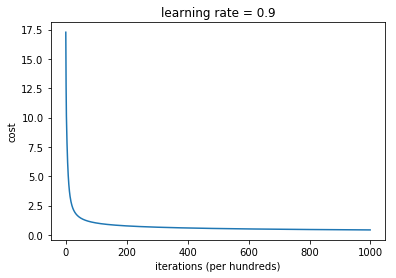

In [16]:
W, b = mclr_model(X_train, Y_train_one_hot, num_iterations = 1000, learning_rate = 0.9, print_cost = True)

In [17]:
def predict(W, b, X):
    """
    Arguments:
    W -- the learned weight matrix (num_feature, num_class)
    b -- the learned bias   matrix (1, num_class)
    X -- input data (m, num_feature)
    
    Return:
    prediction -- softmax vector (1, num_feature)
    """
    A = soft_max(linear_forward(X, W, b))
    
    prediction = np.argmax(A, axis = 1)
    
    return prediction

In [18]:
# Training accuracy
Y_train_hat = predict(W, b, X_train)

m = X_train.shape[0]
num_correct = m - np.count_nonzero((np.squeeze(Y_train) - Y_train_hat))

print("Training accuracy: %f" % float(num_correct / m * 100.0) + "%" )

Training accuracy: 89.333333%


In [19]:
# Testing accuracy
Y_test_hat = predict(W, b, X_test)

m = X_test.shape[0]
num_correct = m - np.count_nonzero((np.squeeze(Y_test) - Y_test_hat))

print("Testing accuracy: %f" % float(num_correct / m * 100.0) + "%" )

Testing accuracy: 88.990476%


OK! We got nearly 90% of accuracy for both training and testing data using the simple linear classifier. In the next notebook, we will build a deeper network which includes more non-linear units to improve the accuracy

## Appendix: Math for binary logistic regression
### For one example $x = \{x_1, \dots, x_n \}$, 
we have $w = \{w_1, \dots, w_n \}$, and $b$

$$z = \sum\limits_{i=1}^{n} w_i x_i + b$$

$$a = \sigma(z) = \frac{1}{1+e^{-z}}$$

Then, the cost function is 
$$ \mathcal{L}(a, y) =  - y  \log(a) - (1-y )  \log(1-a)$$




Now we derive the derivatives for gradient decent:

$$da = -\frac{y}{a} +\frac{1-y}{1-a}$$
$$dz = da*a*(1-a) = a - y$$
$$dw_i = dz * x = (a - y)*x_i$$
$$db = dz = a - y$$

### For vectorization and m training examples:

Given 
$$
X_{(m, n)}
=
\begin{bmatrix} 
\dots x^{(1)} \dots \\
\vdots \\
\dots x^{(m)} \dots \\
\end{bmatrix}
$$

we need to have
$$
W_{(n, 1)}
=
\begin{bmatrix} 
w_1  \\ \vdots \\ w_n \\
\end{bmatrix}
$$

$$
b_{(m, 1)}
=
\begin{bmatrix} 
b_1  \\ \vdots \\ b_m \\
\end{bmatrix}
$$

#### 1. Forward propagation:

$$Z = X W + b$$
$$A = \sigma(Z) $$


#### 2. The cost is then computed by summing over all training examples:

$$ J = \frac{1}{m} ||\mathcal{L}(A, Y)||_F = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

#### 3. Back propagation:
$$dZ = A - Y $$
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X^T(A-Y)$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} (A-Y).sum() = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$